## AP-SVM Data Cleaning Cuts

This notebook takes in a test dataset with predicted SVM labels and plots the energy spectrum before and after cuts.

In [1]:
# Load modules

import json, glob, os
import math, lgdo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from dspeed.vis.waveform_browser import WaveformBrowser

# Plot style 
plt.style.use('seaborn-v0_8-notebook')

# LGDO store
sto = lgdo.lh5.LH5Store()

In [2]:
raw_file = f'../data/test_data_raw.h5'
dsp_file = f'../data/test_data_dsp.h5'

with open("../data/dsp_config_test.json", "r") as f:
    dsp_config = json.load(f)

Here we load parameters into a pandas DataFrame.

In [8]:
df = sto.read('detector/dsp', dsp_file)[0].view_as('pd')

Define maps for SVM categories and colors.

In [9]:
categories_map = {0:'Normal', 1:'Negative Going', 2:'Upwards Sloping', 3:'Downwards Sloping', 
                  4:'Spike', 5:'Crosstalk', 6:'Slow Rise', 7:'Early Trigger', 
                  8:'Late Trigger', 9:'Saturation', 10:'Soft Pileup', 11:'Hard Pileup', 
                  12:'Bump', 13:'Noise Trigger'}
svm_cmap = {0:'blue', 1:'green', 2:'red', 3:'cyan', 
            4:'fuchsia', 5:'gold', 6:'indigo', 7:'grey', 
            8:'maroon', 9:'tab:orange', 10:'hotpink', 11:'magenta', 
            12:'sienna', 13:'purple'}

Plot energy spectrum per category.

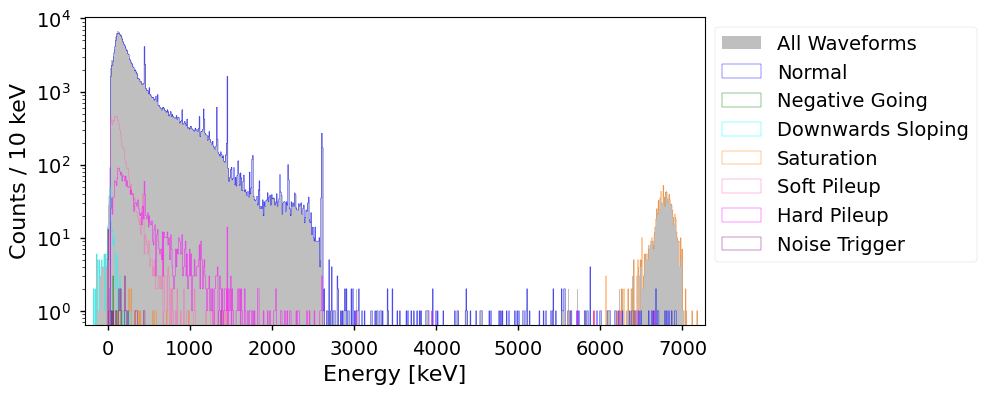

In [20]:
%matplotlib inline

binwidth = 10 # in keV
e_min, e_max = math.floor(df['energy'].min()), math.ceil(df['energy'].max())
# e_min, e_max = -500, math.ceil(df['trapEmax_ctc_cal'].max())
bins = range(e_min, e_max+binwidth, binwidth)

fig= plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, axes_class=matplotlib.axes.Axes)

ax.hist(df['energy'], bins=bins, fill=True, 
        alpha = 0.5, color='grey', label ='All Waveforms')

for label in sorted(df['svm_label'].unique()):
    
    svm_cut = (df['svm_label'] == label)
    ax.hist(df[svm_cut]['energy'], bins=bins, histtype='step',
       color=svm_cmap[label], alpha=1, fill=False, label=categories_map[label]) 

plt.xlim(e_min - 10*binwidth, e_max + 10*binwidth)
plt.xlabel('Energy [keV]', fontsize=16)
plt.ylabel(f'Counts / {binwidth} keV', fontsize=16)
plt.yscale('log')
plt.gca().tick_params(axis='x', labelsize=14) 
plt.gca().tick_params(axis='y', labelsize=14) 
plt.legend(bbox_to_anchor=(1,1), fontsize=14, fancybox=True)

file_format='pdf'
plt.savefig(f"../plots/categories_energy.{file_format}", format=file_format,
            dpi='figure', bbox_inches='tight')

Define the machine learning data cleaning cut.

In [14]:
# Machine learning cut 
ml_dc_cut = (df['svm_label'] == 0) | (df['svm_label'] == 9)

energy_ml_cut = df['energy'][ml_dc_cut]
energy_not_ml_cut = df['energy'][~ml_dc_cut]

We then look at the energy spectrum before and after cuts.

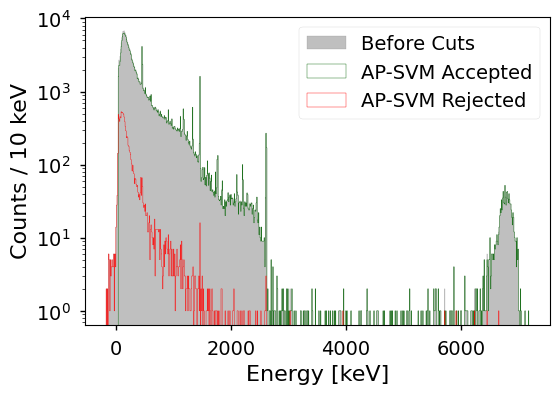

In [19]:
%matplotlib inline

fig= plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, axes_class=matplotlib.axes.Axes)

ax.hist(df['energy'], bins=bins, fill=True, alpha= 0.5, color='grey',
        histtype='step', label =f'Before Cuts')
ax.hist(energy_ml_cut, bins=bins, color='darkgreen',
        label =f'AP-SVM Accepted', histtype='step')
ax.hist(energy_not_ml_cut, bins=bins , color='red',
        label =f'AP-SVM Rejected', histtype='step')

plt.xlabel('Energy [keV]', fontsize=16)
plt.ylabel(f'Counts / {binwidth} keV', fontsize=16)
plt.yscale('log')
plt.gca().tick_params(axis='x', labelsize=14) 
plt.gca().tick_params(axis='y', labelsize=14) 
plt.legend(loc='best', fontsize=14, fancybox=True)

file_format='pdf'
plt.savefig(f"../plots/apsvm_cuts_energy.{file_format}", format=file_format,
            dpi='figure', bbox_inches='tight')